In [ ]:
# Same thing as train_..._circ.ipynb, except I have a smoother transition from the circle in the middle of the domain.\

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_node import NODE, init_layers, NODE_model_aniso, init_params_aniso
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv

from jaxinterp2d import interp2d

from scipy.optimize import fsolve

In [2]:
def nn_fpass(H, params):
    Ws, bs = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    H = jnp.matmul(H, Ws[-1]) + bs[-1]
    return H

def init_params_nn(layers, key):
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))
  return [Ws, bs]

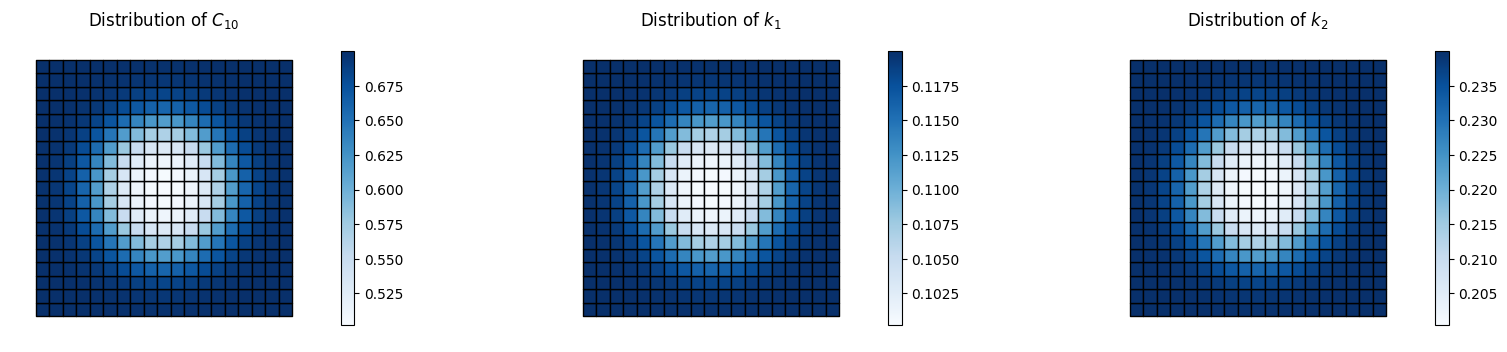

In [69]:
# Generate a synthetic heterogeneous field and assume some boundary conditions
nvar = 2
nrow = 20
ncol = 20
n_node = nrow*ncol
n_elem = n_node-nrow-ncol+1
pts_x = np.linspace(0,1,nrow)
pts_y = np.linspace(0,1,ncol)
node_X, node_Y = np.meshgrid(pts_x,pts_y)
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

# Identify the boundary nodes
rgt_bd = np.where(node_X[:,0]>0.99)
top_bd = np.where(node_X[:,1]>0.99)
lft_bd = np.where(node_X[:,0]<0.01)
bot_bd = np.where(node_X[:,1]<0.01)
rgt_bd_x = node_X[rgt_bd,0].flatten()
rgt_bd_y = node_X[rgt_bd,1].flatten()
top_bd_x = node_X[top_bd,0].flatten()
top_bd_y = node_X[top_bd,1].flatten()
lft_bd_x = node_X[lft_bd,0].flatten()
lft_bd_y = node_X[lft_bd,1].flatten()
bot_bd_x = node_X[bot_bd,0].flatten()
bot_bd_y = node_X[bot_bd,1].flatten()

elements = np.zeros((n_elem, 4), dtype=np.int_)

i=0
j=0
while i < n_node - ncol: #exclude 1 row at the top because there are no nodes above those to form elements.
    if (i+1)%ncol != 0: #Skip the nodes on the right
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+ncol + 1
        elements[j,1] = i+ncol
        j+= 1
    i+= 1

C10 = np.zeros(n_node)
k1  = np.zeros(n_node)
k2  = np.zeros(n_node)

r = np.sqrt((node_X[:,0]-0.5)**2 + (node_X[:,1]-0.5)**2)
r = r/np.max(r)
sigmoid = 1/(1+np.exp(-15*(r-0.35)))
C10 = 0.5 + 0.2*sigmoid
k1  = 0.1 + 0.02*sigmoid
k2  = 0.2 + 0.04*sigmoid

fig, ax = plt.subplots(1,3,figsize=(20,4))
c_elem = 0.25*(C10[elements[:,0]] + C10[elements[:,1]] + C10[elements[:,2]] + C10[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $C_{10}$', ax=ax[0]); 
c_elem = 0.25*(k1[elements[:,0]] + k1[elements[:,1]] + k1[elements[:,2]] + k1[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $k_1$', ax=ax[1]); 
c_elem = 0.25*(k2[elements[:,0]] + k2[elements[:,1]] + k2[elements[:,2]] + k2[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $k_2$', ax=ax[2]); 

Fx = np.random.uniform()+0.5

In [70]:
# Total variation regularization: to help with discontinuous material params

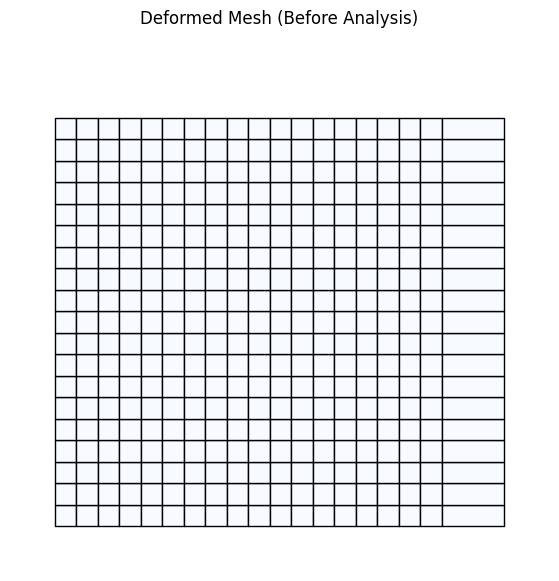

In [71]:
node_x = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 0
        if X[1] < 0.001:
            DOF_fmap[i,1] = -1
            node_x[i,1] = 0
        else:
            DOF_fmap[i,1] = dof
            dof+= 1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.1
        DOF_fmap[i,1] = dof
        dof+= 1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 
plotmesh(elements, node_x, c=np.ones([node_X.shape[0]]), title='Deformed Mesh (Before Analysis)', cbar = False); 

In [72]:
class GOH_SEDF():
    def __init__(self):
        return
    
    def fiberangle(self, node_X):
        return 0.0
    
    def X2params(self, X):
        X_C10    = interp2d(X[0], X[1], pts_x, pts_y,   C10.reshape([nrow,ncol]))
        X_k1     = interp2d(X[0], X[1], pts_x, pts_y,    k1.reshape([nrow,ncol]))
        X_k2     = interp2d(X[0], X[1], pts_x, pts_y,    k2.reshape([nrow,ncol]))
        X_kappa  = 0.1
        return X_C10, X_k1, X_k2, X_kappa

    def Psi_i(self, I1, I2, Iv, Iw, X):
        C10, k1, k2, kappa = self.X2params(X)

        E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E = jnp.maximum(E, 0.0)

        Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
        Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
        Psi2 = 0.0
        Psiw = 0.0
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        C10, k1, k2, kappa = self.X2params(X)

        E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E = jnp.maximum(E, 0.0)

        Psi11 =          kappa**2*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)
        Psi1v = kappa*(1-3*kappa)*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)
        Psivv =    (1-3*kappa)**2*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)

        Psi12 = Psi22 = Psi1w = Psi2v = Psi2w = Psivw = Psiww = 0.0
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

In [73]:
mySEDF = GOH_SEDF()
const_model = vahid_anisohyper_inv(mySEDF)
mysolver = fe_solver_2D(node_X, node_x, elements, DOF_fmap, const_model)
mysolver.n_print = 1
mysolver.itermax = 20
node_x, F, sigma = mysolver.solve()

Solving...
iter 1,   residual = 7603.110746797587
iter 2,   residual = 2790.528338679851
iter 3,   residual = 1023.0909931641656
iter 4,   residual = 374.1621641208796
iter 5,   residual = 136.27875279396
iter 6,   residual = 49.53400115178483
iter 7,   residual = 18.224815151787574
iter 8,   residual = 6.961888442330066
iter 9,   residual = 2.805373018425062
iter 10,   residual = 1.1591842906897898
iter 11,   residual = 0.3211928022972959
iter 12,   residual = 0.05762778375053662
iter 13,   residual = 0.0015356044579247308
iter 14,   residual = 0.00010200796906076154
iter 15,   residual = 7.204707397058316e-06
Solution converged!


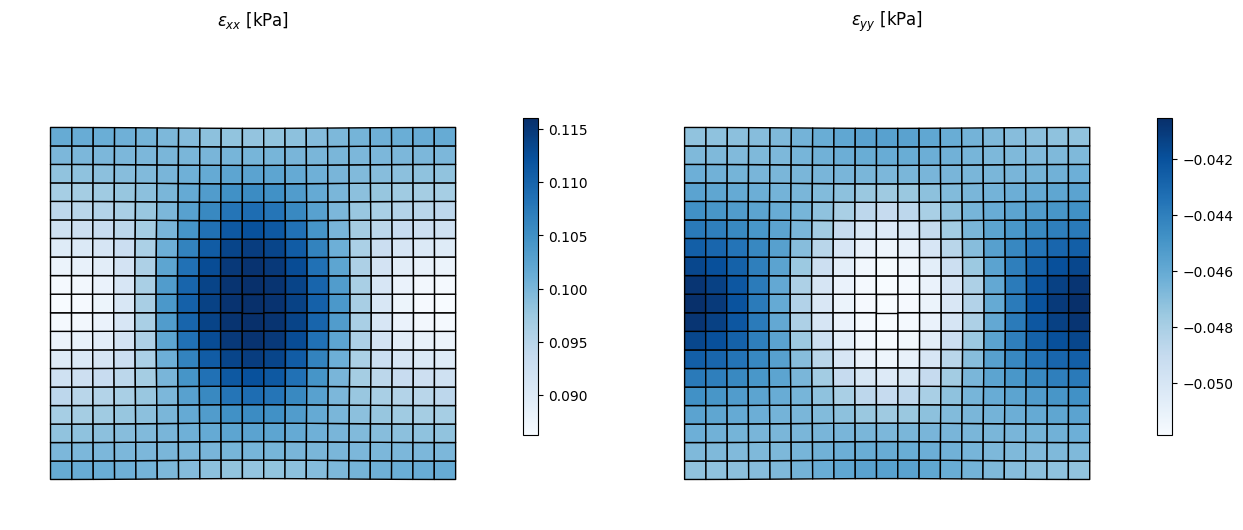

In [74]:
epsx = F[:,0,0]-1.0
epsy = F[:,1,1]-1.0
strains = np.array([epsx, epsy])

fig, axes = plt.subplots(1,2,figsize=(15,7))
plotmesh(elements, node_x, epsx, title='$\epsilon_{xx}$ [kPa]', ax=axes[0]); 
plotmesh(elements, node_x, epsy, title='$\epsilon_{yy}$ [kPa]', ax=axes[1]); 

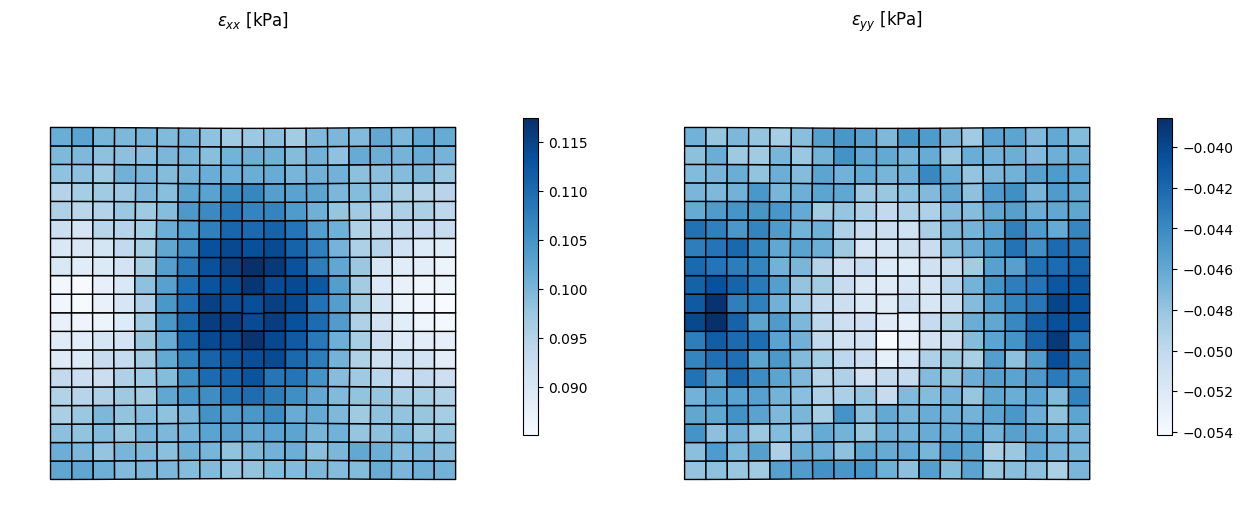

In [9]:
epsx, epsy = strains
x_noisy = epsx + np.random.normal(size=len(epsx), loc=0, scale=0.001)
y_noisy = epsy + np.random.normal(size=len(epsy), loc=0, scale=0.001)
fig, axes = plt.subplots(1,2,figsize=(15,7))
plotmesh(elements, node_x, x_noisy, title='$\epsilon_{xx}$ [kPa]', ax=axes[0]); 
plotmesh(elements, node_x, y_noisy, title='$\epsilon_{yy}$ [kPa]', ax=axes[1]); 

In [10]:
epsx = x_noisy
epsy = y_noisy
strains = np.array([epsx, epsy])

In [ ]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(elements):
    if any([node_X[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([node_X[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([node_X[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([node_X[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(sigma[rgt_bd_elems,0,0])
lft_bd_frc = np.sum(sigma[lft_bd_elems,0,0])
top_bd_frc = np.sum(sigma[top_bd_elems,1,1])
bot_bd_frc = np.sum(sigma[bot_bd_elems,1,1])
Fx = 0.5*(rgt_bd_frc + lft_bd_frc)
Fy = 0.5*(top_bd_frc + bot_bd_frc)

# get the center points of the elements
elem_X = np.array([0.25*(node_X[e[0]] + node_X[e[1]] + node_X[e[2]] + node_X[e[3]]) for e in elements])
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]

In [12]:
# Homogenize the strains
epsx_mean = np.mean(strains[0])
epsy_mean = np.mean(strains[1])
sgmx_mean = Fx/len(rgt_bd_elems)
sgmy_mean = Fy/len(top_bd_elems)
lamb_sigma_m = np.array([epsx_mean+1.0, epsy_mean+1.0, sgmx_mean, sgmy_mean]).reshape([1,-1])

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, key):
    model   = NODE_model_aniso(params)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sgmx_gt  = lamb_sigma[:,2]
    sgmy_gt  = lamb_sigma[:,3]
    sgm = eval_Cauchy_aniso_vmap(lambx,lamby, model)
    sgmx_pr, sgmy_pr = sgm[:,0,0], sgm[:,1,1]
    return np.mean((sgmx_pr-sgmx_gt)**2+(sgmy_pr-sgmy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000)

it 1000, train loss = 1.398881e-03
it 2000, train loss = 1.608050e-04
it 3000, train loss = 4.951812e-05
it 4000, train loss = 1.934391e-05
it 5000, train loss = 8.122357e-06
it 6000, train loss = 3.484925e-06
it 7000, train loss = 1.505621e-06
it 8000, train loss = 6.559700e-07
it 9000, train loss = 2.912370e-07
it 10000, train loss = 1.339049e-07


In [13]:
mymodel = NODE_model_aniso(node_params)
sgm = eval_Cauchy_aniso(epsx_mean+1.0,epsy_mean+1.0, mymodel)
sgmx, sgmy = sgm[0,0], sgm[1,1]
print('gt sgmx & sgmy: ', sgmx_mean, sgmy_mean)
print('pr sgmx & sgmy: ', sgmx, sgmy)

gt sgmx & sgmy:  0.42292359440434935 1.8140746170336855e-05
pr sgmx & sgmy:  0.4229235141150743 0.00038407093440814285


In [14]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

def loss_Lambda(params, inp, key):
    out_pr = nn_fpass(inp, params)
    return jnp.mean((out_pr-phi)**2)

Lambda_layers = [2,5,10,n_phi]
Lambda_params = init_params_nn(Lambda_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 2000, print_freq=1000)

it 1000, train loss = 4.113705e-03
it 2000, train loss = 6.217933e-04


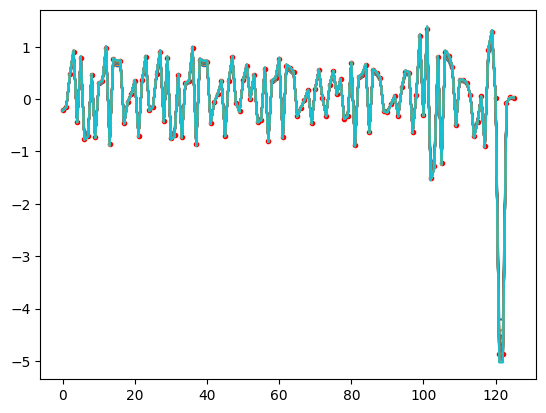

In [15]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = nn_fpass(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [17]:
with open('params/circ_noisy_trndata_and_init.npy', 'wb') as f:
    pickle.dump([node_X, node_x, elements, n_node, n_elem, Fx, Fy, strains, elem_X, node_params,
                 rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X, rgt_bd_elems, top_bd_elems, lft_bd_elems, bot_bd_elems, Lambda_params], f)

In [3]:
with open('params/circ_noisy_trndata_and_init.npy', 'rb') as f:
    node_X, node_x, elements, n_node, n_elem, Fx, Fy, strains, elem_X, node_params, \
                 rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X, rgt_bd_elems, top_bd_elems, lft_bd_elems, bot_bd_elems, Lambda_params = pickle.load(f)
_, unravel = ravel_pytree(node_params)

In [4]:
# Train with the heterogeneity
def get_stresses(x, y, Lambda_params):
    # get the strains for this x and y using 2D interpolation
    n = int(np.sqrt(len(elements)))
    pts_x = elem_X[[i*n for i in range(n)],0] # for x we need to take points 1, n, 2n, ..., nn
    pts_y = elem_X[:n,1] # for y we need to take points 1, 2, 3, ... n
    strains_x = strains[0].reshape([n,n])
    strains_y = strains[1].reshape([n,n])
    epsx = interp2d(x, y, pts_x, pts_y, strains_x)
    epsy = interp2d(x, y, pts_x, pts_y, strains_y)

    # get NODE individual-specific params, phi, from the Lambda NN
    Lambda_inp = jnp.array([x,y]).reshape([-1,2])
    phi = nn_fpass(Lambda_inp, Lambda_params).flatten()
    # Make predictions with this NODE
    mymodel = NODE_model_aniso(unravel(phi))
    sgm = eval_Cauchy_aniso(epsx+1.0,epsy+1.0, mymodel)
    return sgm[0,0], sgm[1,0], sgm[0,1], sgm[1,1]
get_stresses_vmap = vmap(get_stresses, in_axes=(0,0,None), out_axes=(0,0,0,0))

get_sgm_xx = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[0]
get_sgm_yx = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[1]
get_sgm_xy = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[2]
get_sgm_yy = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[3]

grad_sgm_xx_x = vmap(grad(get_sgm_xx, argnums=0), in_axes=(0,0,None), out_axes=0) # should return dsgm_xx/dx
grad_sgm_yx_x = vmap(grad(get_sgm_yx, argnums=0), in_axes=(0,0,None), out_axes=0)
grad_sgm_xy_y = vmap(grad(get_sgm_yx, argnums=1), in_axes=(0,0,None), out_axes=0)
grad_sgm_yy_y = vmap(grad(get_sgm_yy, argnums=1), in_axes=(0,0,None), out_axes=0)

@jit
def bd_forces(Lambda_params, input):
    rgt_bd_sgm = get_stresses_vmap(rgt_bd_X[:,0], rgt_bd_X[:,1], Lambda_params)
    top_bd_sgm = get_stresses_vmap(top_bd_X[:,0], top_bd_X[:,1], Lambda_params)
    lft_bd_sgm = get_stresses_vmap(lft_bd_X[:,0], lft_bd_X[:,1], Lambda_params)
    bot_bd_sgm = get_stresses_vmap(bot_bd_X[:,0], bot_bd_X[:,1], Lambda_params)

    rgt_bd_frc = jnp.sum(rgt_bd_sgm[0]) # Assume area of edge = 1.0
    top_bd_frc = jnp.sum(top_bd_sgm[3])
    lft_bd_frc = jnp.sum(lft_bd_sgm[0])
    bot_bd_frc = jnp.sum(bot_bd_sgm[3])
    return rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc
@jit
def divergence(Lambda_params, X_colloc):
    # X_colloc = random.uniform(key, (500,2))
    dsgm_xx_dx = grad_sgm_xx_x(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_xy_dy = grad_sgm_xy_y(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_yx_dx = grad_sgm_yx_x(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_yy_dy = grad_sgm_yy_y(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    
    div_x = jnp.sum(dsgm_xx_dx + dsgm_xy_dy) # = dsgm_xx/dx + dsgm_xy/dy
    div_y = jnp.sum(dsgm_yx_dx + dsgm_yy_dy) # = dsgm_yx/dx + dsgm_yy/dy
    return div_x, div_y
@jit
def loss(Lambda_params, X_colloc):
    div_x, div_y = divergence(Lambda_params, X_colloc)
    rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc = bd_forces(Lambda_params, None)
    return div_x**2 + div_y**2 + 10*((rgt_bd_frc-Fx)**2 + (top_bd_frc-Fy)**2 + (lft_bd_frc-Fx)**2 + (bot_bd_frc-Fy)**2)

@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None):
    val_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        X_colloc = random.uniform(key, (50,2))
        opt_state = step(loss, it, get_params, opt_update, opt_state, X_colloc)
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            val_loss_value = loss(params, X)
            val_loss.append(val_loss_value)
            if metric_fns is not None:
                m = []
                for metric_fn in metric_fns:
                    m.append(metric_fn(params, X))
                metrics.append(m)
            to_print = "it %i, val loss = %e" % (it+1, val_loss_value)
            print(to_print)
    return get_params(opt_state), val_loss, metrics

opt_init, opt_update, get_params = optimizers.adam(5.0e-4)
opt_state = opt_init(Lambda_params)
Lambda_params, val_loss, metrics = train(loss, node_X, get_params, opt_update, opt_state, 
                                              key, nIter = 1_000_000, print_freq=1000, metric_fns=[bd_forces, divergence])
with open('params/circ_noisy.npy', 'wb') as f:
    pickle.dump([node_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics], f)

it 1000, val loss = 9.926431e+00
it 2000, val loss = 5.360223e+00
it 3000, val loss = 3.168176e+00
it 4000, val loss = 9.821858e+00
it 5000, val loss = 3.673586e+00
it 6000, val loss = 7.220375e+00
it 7000, val loss = 1.690747e+01
it 8000, val loss = 1.129974e+00
it 9000, val loss = 1.293261e+01
it 10000, val loss = 4.784552e+00
it 11000, val loss = 1.729102e+00
it 12000, val loss = 2.808632e+01
it 13000, val loss = 1.369352e+01
it 14000, val loss = 1.254638e+01
it 15000, val loss = 1.981117e-01
it 16000, val loss = 4.476162e-01
it 17000, val loss = 3.849869e+00
it 18000, val loss = 3.768771e-02
it 19000, val loss = 5.038152e+00
it 20000, val loss = 8.977072e+00
it 21000, val loss = 4.687605e+00
it 22000, val loss = 7.534318e+00
it 23000, val loss = 9.997097e-01
it 24000, val loss = 5.341079e-01
it 25000, val loss = 3.265330e+00
it 26000, val loss = 5.406375e+00
it 27000, val loss = 1.014560e-01
it 28000, val loss = 7.917507e+00
it 29000, val loss = 7.229900e+00
it 30000, val loss = 1.

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_69334/1681094404.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  forces, div = np.array(metrics).T


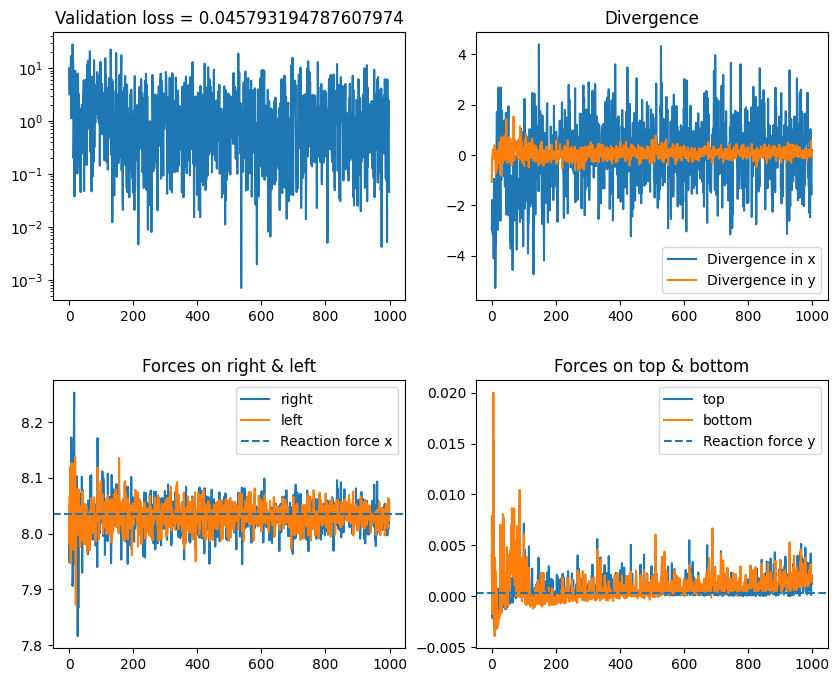

In [5]:
forces, div = np.array(metrics).T
forces = np.array([*forces])
div = np.array([*div])

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(val_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Fx, linestyle='--', label='Reaction force x')
ax[1,1].axhline(Fy, linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Validation loss = ' + str(val_loss[-1]), yscale = 'log')
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [6]:
with open('params/circ_noisy.npy', 'rb') as f:
    node_X, strains, Fx, Fy, node_params, Lambda_params, train_loss, metrics = pickle.load(f)
_, unravel = ravel_pytree(node_params)

In [7]:
class NODE_SEDF_aniso():
    def __init__(self, Lambda_params=None, unravel=None):
        self.Lambda_params = Lambda_params
        self.unravel = unravel
        return
    def nn_fpass(self, H, params):
        Ws, bs = params
        N_layers = len(Ws)
        for i in range(N_layers - 1):
            H = jnp.matmul(H, Ws[i]) + bs[i]
            H = jnp.tanh(H)
        H = jnp.matmul(H, Ws[-1]) + bs[-1]
        return H
    def X2params(self, X):
        Lambda_inp = np.array([X[0],X[1]]).reshape([-1,2])
        phi = self.nn_fpass(Lambda_inp, self.Lambda_params).flatten()
        params = self.unravel(phi)
        return params
    def fiberangle(self, node_X):
        return 0.0
    
    def Psi_i(self, I1, I2, Iv, Iw, X):
        params = self.X2params(X)
        model = NODE_model_aniso(params)
        Psi1 = model.Psi1(I1,I2,Iv,Iw)
        Psi2 = model.Psi2(I1,I2,Iv,Iw)
        Psiv = model.Psiv(I1,I2,Iv,Iw)
        Psiw = model.Psiw(I1,I2,Iv,Iw)
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        params = self.X2params(X)
        model = NODE_model_aniso(params)
        
        e = 1.0e-6
        Psi1_p = model.Psi1(I1+e,I2,Iv,Iw)
        Psi1_m = model.Psi1(I1-e,I2,Iv,Iw)
        Psi2_p = model.Psi2(I1+e,I2,Iv,Iw)
        Psi2_m = model.Psi2(I1-e,I2,Iv,Iw)
        Psiv_p = model.Psiv(I1+e,I2,Iv,Iw)
        Psiv_m = model.Psiv(I1-e,I2,Iv,Iw)
        Psiw_p = model.Psiw(I1+e,I2,Iv,Iw)
        Psiw_m = model.Psiw(I1-e,I2,Iv,Iw)
        Psi11 = (Psi1_p-Psi1_m)/2/e
        Psi12 = (Psi2_p-Psi2_m)/2/e
        Psi1v = (Psiv_p-Psiv_m)/2/e
        Psi1w = (Psiw_p-Psiw_m)/2/e

        Psi2_p = model.Psi2(I1,I2+e,Iv,Iw)
        Psi2_m = model.Psi2(I1,I2-e,Iv,Iw)
        Psiv_p = model.Psiv(I1,I2+e,Iv,Iw)
        Psiv_m = model.Psiv(I1,I2-e,Iv,Iw)
        Psiw_p = model.Psiw(I1,I2+e,Iv,Iw)
        Psiw_m = model.Psiw(I1,I2-e,Iv,Iw)
        Psi22 = (Psi2_p-Psi2_m)/2/e
        Psi2v = (Psiv_p-Psiv_m)/2/e
        Psi2w = (Psiw_p-Psiw_m)/2/e

        Psiv_p = model.Psiv(I1,I2,Iv+e,Iw)
        Psiv_m = model.Psiv(I1,I2,Iv-e,Iw)
        Psiw_p = model.Psiw(I1,I2,Iv+e,Iw)
        Psiw_m = model.Psiw(I1,I2,Iv-e,Iw)
        Psivv = (Psiv_p-Psiv_m)/2/e
        Psivw = (Psiw_p-Psiw_m)/2/e

        Psiw_p = model.Psiw(I1,I2,Iv,Iw+e)
        Psiw_m = model.Psiw(I1,I2,Iv,Iw-e)
        Psiww = (Psiw_p-Psiw_m)/2/e
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

In [8]:
node_x2 = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x2[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        node_x2[i,0] = 0
        if X[1] < 0.001:
            DOF_fmap[i,1] = -1
            node_x2[i,1] = 0
        else:
            DOF_fmap[i,1] = dof
            dof+= 1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x2[i,0] = 1.1
        DOF_fmap[i,1] = dof
        dof+= 1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 

mySEDF = NODE_SEDF_aniso(Lambda_params, unravel)
const_model = vahid_anisohyper_inv(mySEDF)
mysolver = fe_solver_2D(node_X, node_x2, elements, DOF_fmap, const_model)
mysolver.n_print = 1
mysolver.itermax = 20
node_x2, F, sigma = mysolver.solve()

Solving...
iter 1,   residual = 34.07452517015284
iter 2,   residual = 5.973789275347175
iter 3,   residual = 1.2358875193978143
iter 4,   residual = 0.22661317832703612
iter 5,   residual = 0.027912040156681417
iter 6,   residual = 0.0035521245495576145
iter 7,   residual = 0.000957421360481817
iter 8,   residual = 0.0006197635557520913
iter 9,   residual = 0.00017643990802698793
iter 10,   residual = 1.582218776067843e-05
iter 11,   residual = 1.068117116179568e-06
Solution converged!


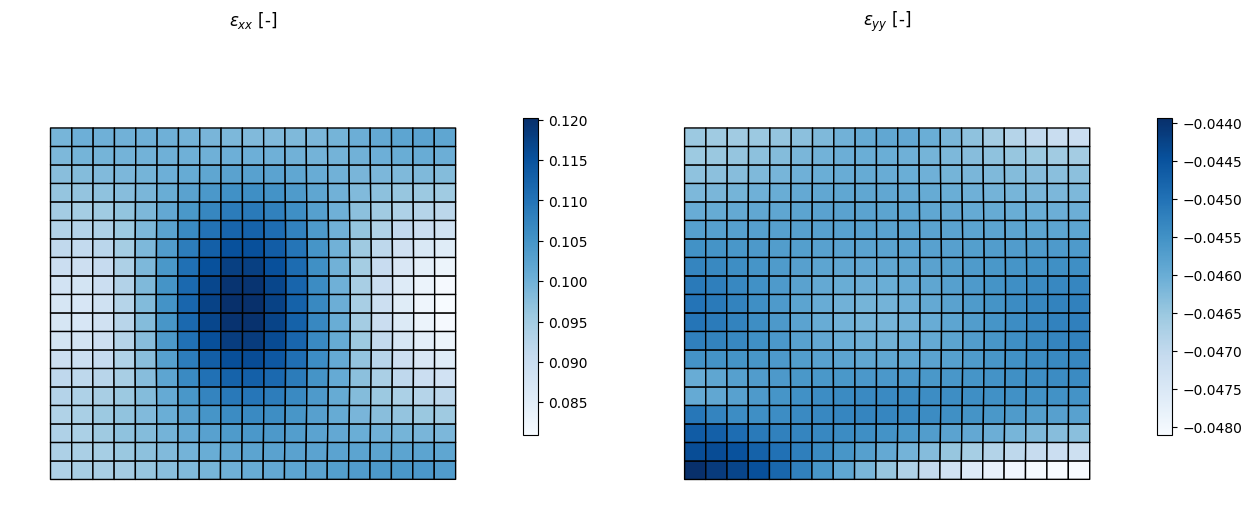

In [9]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
plotmesh(elements, node_x2, F[:,0,0]-1.0, title='$\epsilon_{xx}$ [-]', ax=axes[0]); 
plotmesh(elements, node_x2, F[:,1,1]-1.0, title='$\epsilon_{yy}$ [-]', ax=axes[1]); 

In [37]:
with open('params/circ_noisy_recon.npy', 'wb') as f:
    pickle.dump([node_x2, F, sigma],f)